In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from nltk.sentiment import SentimentIntensityAnalyzer
import torch
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

WEB SCRAPING

In [3]:
# downloading and saving the HTML content using Selenium
def download_html(driver, file_path):
    time.sleep(5) 
    # save the page source (HTML) to a file
    html_content = driver.page_source
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(html_content)

In [4]:
# extracting reviews
def get_reviews(soup):
    reviews_list = []

    # finding the review elements
    reviews = soup.find_all('div', {'data-hook': 'review'})
    if not reviews:
        print("No reviews found on this page.")
        exit()
        return reviews_list

    for review in reviews:
        try:
            # review title
            title_element = review.find('a', {'data-hook': 'review-title'})
            title = title_element.text.strip().split("\n")[-1] if title_element else 'No title'

            # review body
            body_element = review.find('span', {'data-hook': 'review-body'})
            body = body_element.text.strip() if body_element else 'No body'

            # review rating
            rating_element = review.find('i', {'data-hook': 'review-star-rating'})
            rating = rating_element.text.strip() if rating_element else 'No rating'

            # review date
            date_element = review.find('span', {'data-hook': 'review-date'})
            date = date_element.text.strip() if date_element else 'No date'

            reviews_list.append({
                "title": title,
                "body": body,
                "rating": rating,
                "date": date
            })
        except AttributeError as e:
            print(f"Error parsing review: {e}")
    
    return reviews_list

In [5]:
# main function to scrape reviews, putting it into a data frame
def scrape(asin):
    html_file_path = 'amazon_reviews.html'
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  
    driver = webdriver.Chrome(options=options)

    dataframe = pd.DataFrame(columns = ["title", "body", "rating", "date"])
    t = []
    b = []
    r = []
    d = []

    try:
        for page_number in range(1,11):
            url = f'https://www.amazon.com/product-reviews/{asin}/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=' + str(page_number)
            driver.get(url)
            download_html(driver, html_file_path)
            with open(html_file_path, 'r', encoding='utf-8') as file:
                html_content = file.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            reviews = get_reviews(soup)
            if not reviews and page_number == 1:  # if no reviews found on the first page => break the loop
                break
            for review in reviews:
                t.append(review["title"])
                b.append(review["body"])
                r.append(review["rating"])
                d.append(review["date"])
            

    finally:
        driver.quit()
    
    dataframe["title"] = t
    dataframe["body"] = b
    dataframe["rating"] = r
    dataframe["date"] = d
    return dataframe

In [6]:
df = scrape(asin = 'B0B3HM3FTZ')

In [4]:
# changing the rating string into an integer representing stars
df["rating"] = df["rating"].apply(lambda x: int(x.split(".")[0]))

# extracting the date from the scraped date info and converting it into a datetime object
df["date"] = df["date"].apply(lambda x: x.split("on")[-1])
df["date"] = pd.to_datetime(df["date"])

In [3]:
#RUN ONLY IF YOU DON'T WANT TO SCRAPE AMAZON FOR THE 100th TIME OF THE DAY :))
df = pd.read_csv("chairs.csv")
df.head()


,title,body,rating,date
0,Comfortable and easy to assemble,"Ordered this to replace an old chair, and I'm ...",5.0 out of 5 stars,"Reviewed in the United States on May 13, 2023"
1,Game changer!! (no pun intended),"I decided I needed an office chair upgrade, du...",5.0 out of 5 stars,"Reviewed in the United States on April 19, 2024"
2,It’s actually great. Definitely recommend.,The media could not be loaded.\n ...,4.0 out of 5 stars,"Reviewed in the United States on May 12, 2023"
3,Broken Arm,Chair came with a broken arm. We sent an email...,5.0 out of 5 stars,"Reviewed in the United States on March 24, 2024"
4,It has it's ups and downs until it doesn't go ...,I bought this chair in 2023 and it actually on...,1.0 out of 5 stars,"Reviewed in the United States on January 11, 2024"


SENTIMENT ANALYSIS MODELS

In [5]:
# VADER model
sia = SentimentIntensityAnalyzer()

# predicting the sentiment for each review of the dataset
vader = {}
i = 0
for review in df["body"]:
    vader[i] = {
        "Vnegative": sia.polarity_scores(review)["neg"],
        "Vneutral": sia.polarity_scores(review)["neu"],
        "Vpositive": sia.polarity_scores(review)["pos"],
        "Vcompound": sia.polarity_scores(review)["compound"]
    }
    i += 1

# putting the results into an initial dataframe
df_v = pd.DataFrame(vader).T
df_v = pd.concat([df, df_v], axis = 1)
df_v

,title,body,rating,date,Vnegative,Vneutral,Vpositive,Vcompound
0,Comfortable and easy to assemble,"Ordered this to replace an old chair, and I'm ...",5,2023-05-13,0.061,0.863,0.075,0.4033
1,Game changer!! (no pun intended),"I decided I needed an office chair upgrade, du...",5,2024-04-19,0.023,0.748,0.229,0.9796
2,It’s actually great. Definitely recommend.,The media could not be loaded.\n ...,4,2023-05-12,0.046,0.762,0.192,0.9936
3,Broken Arm,Chair came with a broken arm. We sent an email...,5,2024-03-24,0.162,0.706,0.132,-0.0387
4,It has it's ups and downs until it doesn't go ...,I bought this chair in 2023 and it actually on...,1,2024-01-11,0.074,0.813,0.113,0.9541
...,...,...,...,...,...,...,...,...
95,Ehh it's OK,Affordable? Yes. Comfortable? Not so much. The...,3,2023-06-24,0.062,0.798,0.141,0.7032
96,Awesome chair !,I got this chair for my boyfriend for his birt...,5,2023-09-13,0.012,0.758,0.230,0.9663
97,broke after a few months **edited**,"cheap parts, not worth the value, metal bends ...",5,2023-10-26,0.064,0.764,0.172,0.7350
98,Not recommended,Bought for less a month. The feet pad is compl...,2,2024-04-03,0.076,0.858,0.066,-0.1082


In [21]:
# ROBERTA PRETRAINED MODEL (takes context into account)
#???????????????? this always crashes my kernel if I don't run it at the beginning of my script

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# load tokenizer and model (sometimes crashed kernel so had to include try, except)
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    # check if GPU is available and use it, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Model and tokenizer loaded successfully on {device}!")
except Exception as e:
    print(f"An error occurred: {e}")


/Users/mariannazapotokova/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


: 

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

# Load tokenizer and model (sometimes crashes kernel so had to include try, except)
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    # Check if GPU is available and use it, otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(f"Model and tokenizer loaded successfully on {device}!")
except Exception as e:
    print(f"An error occurred: {e}")


/Users/mariannazapotokova/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model and tokenizer loaded successfully on cpu!


In [6]:
# predicting the sentiment for each review of the dataset
robertamodel = {}
x = 0
for review in df["body"]:
    try:
        encoded = tokenizer(review, return_tensors="pt")
        modelled = model(**encoded)
        roberta = modelled[0][0].detach().numpy()
        roberta = softmax(roberta)
        robertamodel[x] = {
            "Rnegative": roberta[0],
            "Rneutral": roberta[1],
            "Rpositive": roberta[2]
        }
        x += 1
    except RuntimeError:
        print(f"can't process the text in index {x}")
        x += 1

# concatenating all dataframes together
df_r = pd.DataFrame(robertamodel).T

df_sentiment = pd.concat([df_v, df_r], axis = 1)
df_sentiment.head()


can't process the text in index 4


,title,body,rating,date,Vnegative,Vneutral,Vpositive,Vcompound,Rnegative,Rneutral,Rpositive
0,Comfortable and easy to assemble,"Ordered this to replace an old chair, and I'm ...",5,2023-05-13,0.061,0.863,0.075,0.4033,0.311303,0.431875,0.256822
1,Game changer!! (no pun intended),"I decided I needed an office chair upgrade, du...",5,2024-04-19,0.023,0.748,0.229,0.9796,0.002937,0.010761,0.986301
2,It’s actually great. Definitely recommend.,The media could not be loaded.\n ...,4,2023-05-12,0.046,0.762,0.192,0.9936,0.029140,0.114318,0.856542
3,Broken Arm,Chair came with a broken arm. We sent an email...,5,2024-03-24,0.162,0.706,0.132,-0.0387,0.187441,0.320788,0.491771
4,It has it's ups and downs until it doesn't go ...,I bought this chair in 2023 and it actually on...,1,2024-01-11,0.074,0.813,0.113,0.9541,NaN,NaN,NaN


VISUALISATIONS

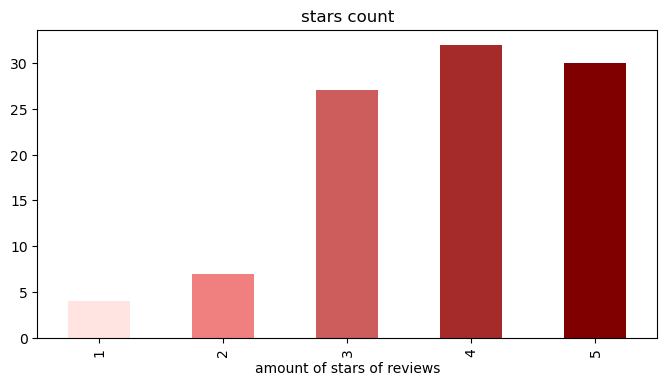

In [7]:
# distribution of stars given to the product
plt.figure(figsize=(10,4))
colors = ["mistyrose", "lightcoral", "indianred", "brown", "maroon"]
ax = df["rating"].value_counts().sort_index().plot.bar(title='stars count', figsize=(8,4), color = colors)
ax.set_xlabel("amount of stars of reviews")
plt.show()

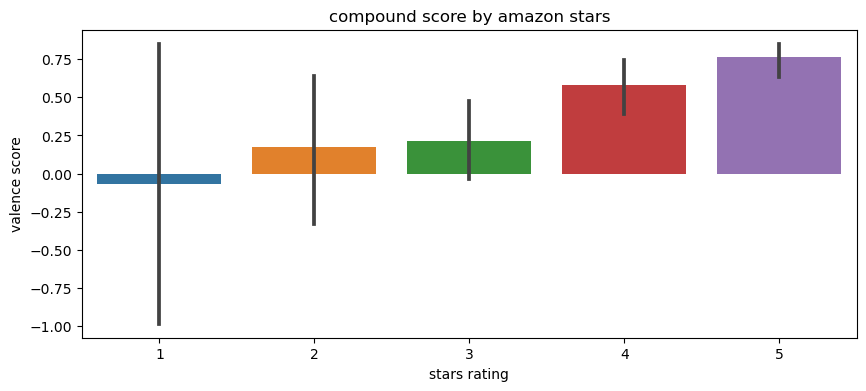

In [9]:
# barplot which shows the typical predicted valence by VADER model for each "star group"
plt.figure(figsize = (10,4))
ax = sns.barplot(df_v, x = "rating", y = "Vcompound")
ax.set_title("compound score by amazon stars")
ax.set_xlabel("stars rating")
ax.set_ylabel("valence score")
plt.show()

/Users/mariannazapotokova/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/mariannazapotokova/anaconda3/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


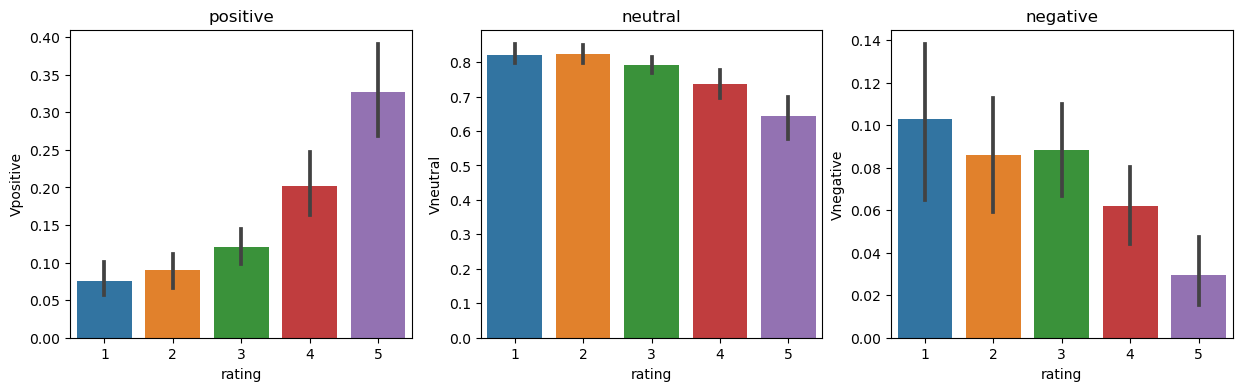

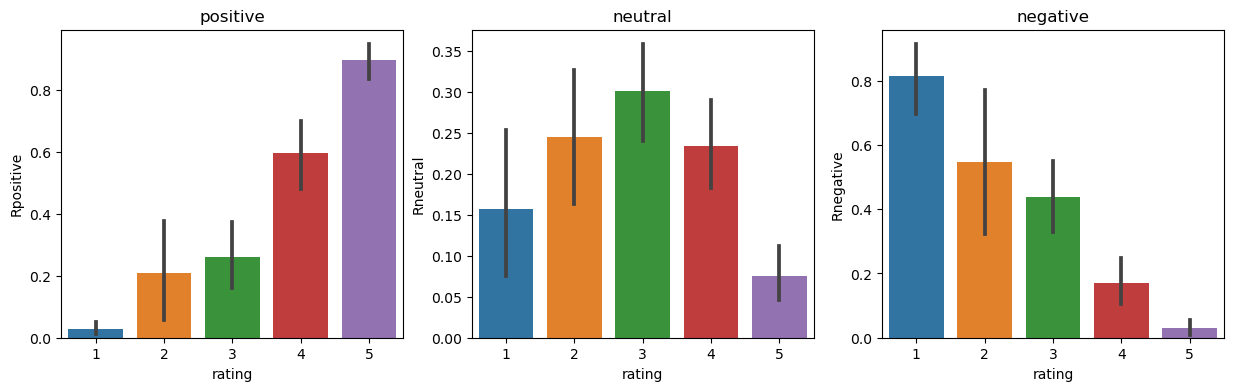

In [10]:
# barplot which displays the typical predicted (pos/neu/neg) valence by both models for each "star group"
def pnn_plots(model):
    fig, axs = plt.subplots(1,3, figsize = (15,4))
    sns.barplot(df_sentiment, x = "rating", y = f"{model}positive", ax = axs[0])
    sns.barplot(df_sentiment, x = "rating", y = f"{model}neutral", ax = axs[1])
    sns.barplot(df_sentiment, x = "rating", y = f"{model}negative", ax = axs[2])
    axs[0].set_title("positive")
    axs[1].set_title("neutral")
    axs[2].set_title("negative")

pnn_plots("V")
pnn_plots("R")

/Users/mariannazapotokova/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


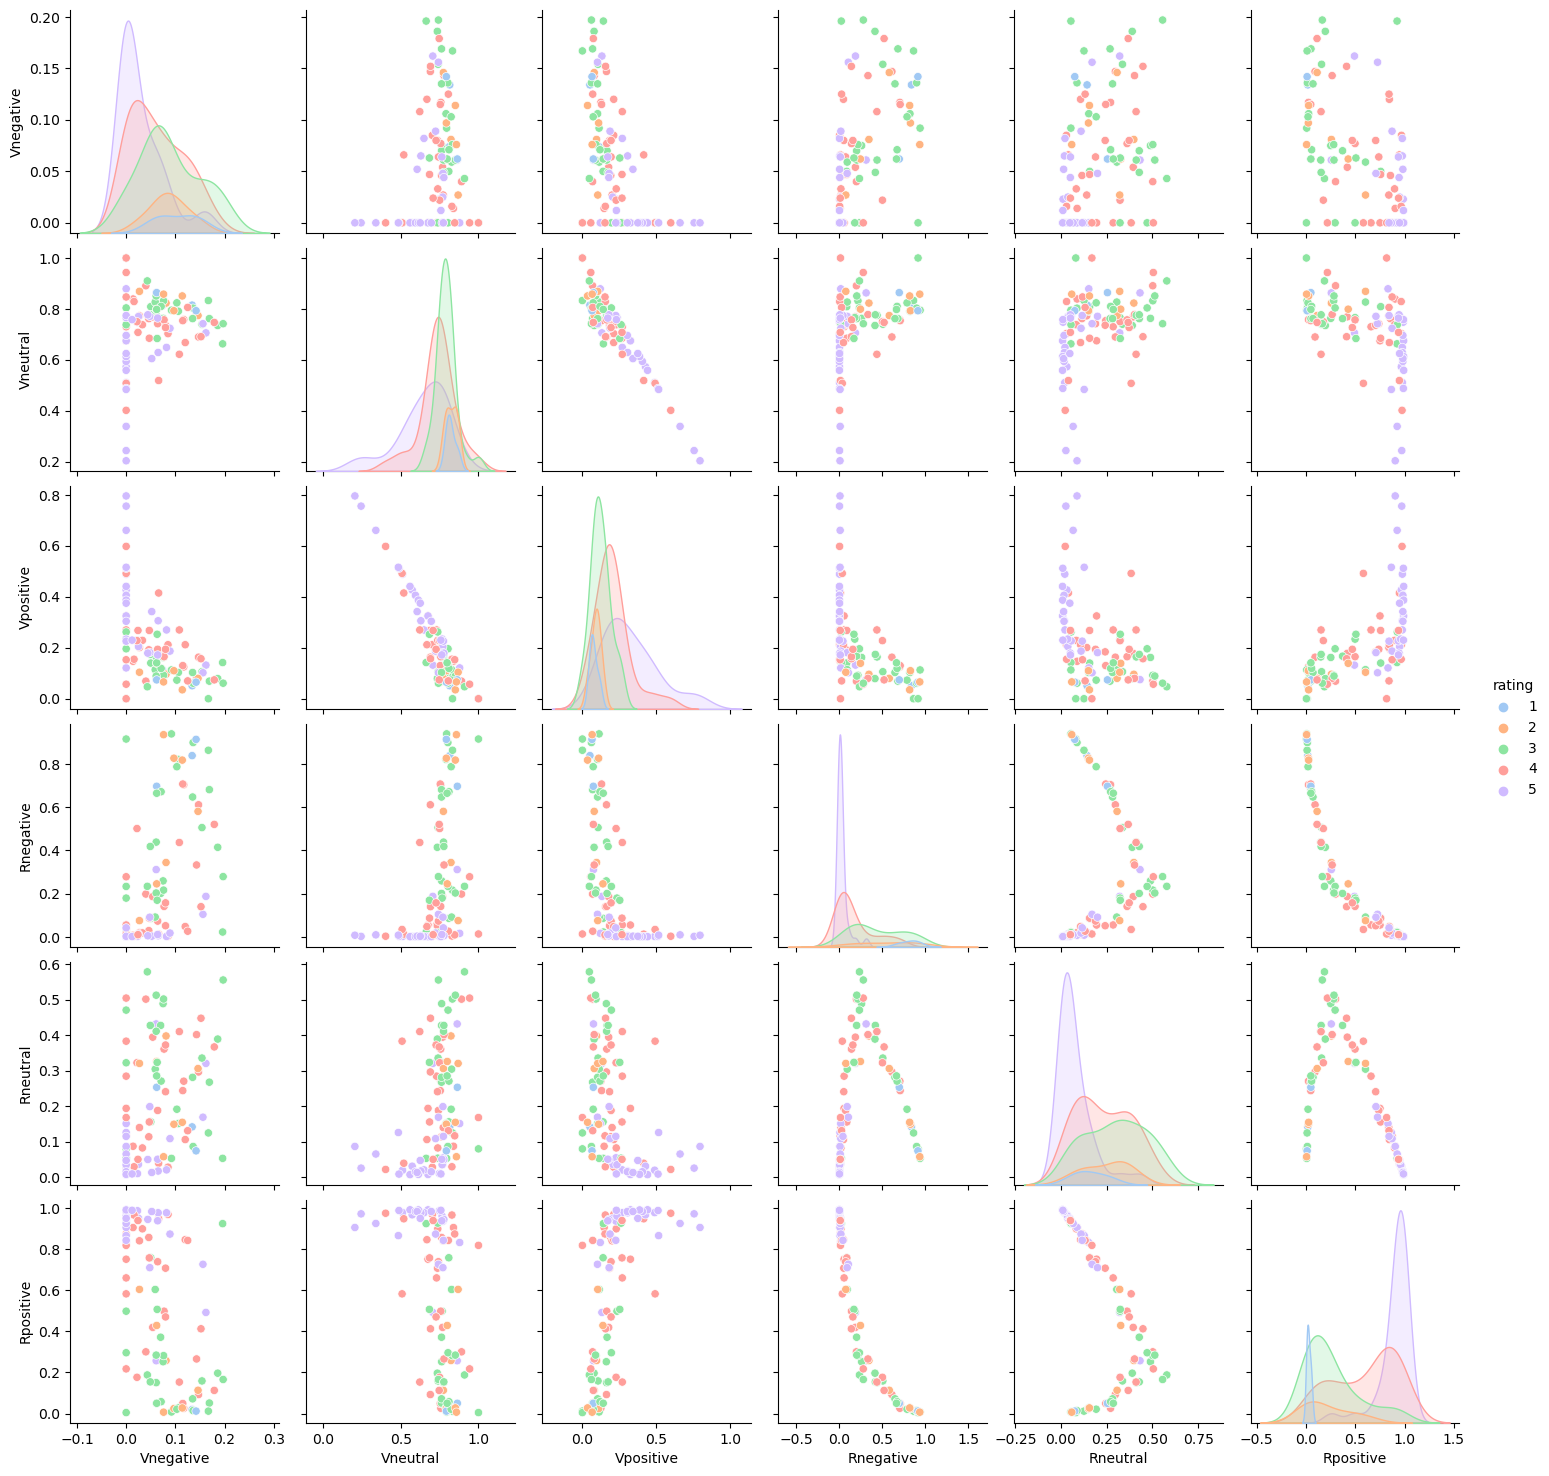

In [11]:
#comparing scores between models
sns.pairplot(data = df_sentiment, vars= ['Vnegative', 'Vneutral', 'Vpositive'
                                       ,'Rnegative', 'Rneutral', 'Rpositive'],
                hue = "rating",
                palette="pastel")
plt.show()

USEFUL FOR CUSTOMER

Text(0.5, 1.0, 'overall sentiment predicted by the VADER model throughout time')

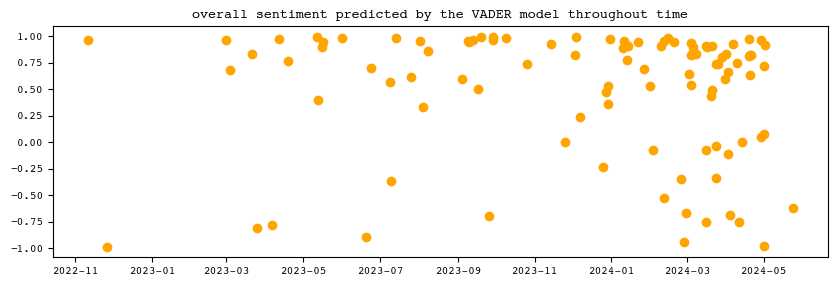

In [12]:
# VADER compound sentiment shown over time
plt.figure(figsize = (10,3))
plt.rc('font', family='Courier', size=8)
plt.scatter(x = df_sentiment["date"], y = df_sentiment["Vcompound"], color = "orange")
plt.title("overall sentiment predicted by the VADER model throughout time")


Text(0.5, 1.0, 'negative sentiment predicted by the roberta model throught time')

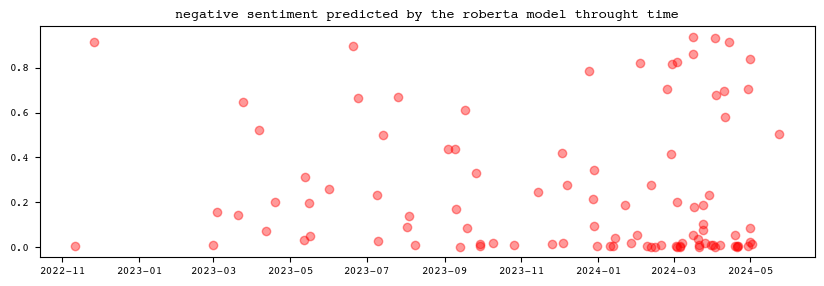

In [13]:
# roBERTa negative sentiment shown over time
plt.figure(figsize=(10,3))
plt.scatter(x = df_sentiment["date"], y = df_sentiment["Rnegative"], color = "red", alpha = 0.4)
plt.title("negative sentiment predicted by the roberta model throught time")

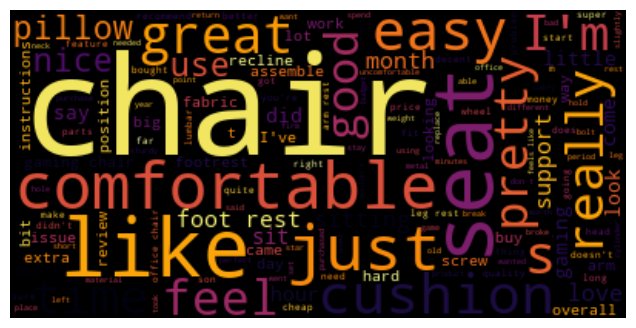

In [14]:
# word cloud displaying the most used words in all of the reviews
reviews = "".join(i for i in df_sentiment["body"])
cloud = WordCloud(stopwords = ENGLISH_STOP_WORDS, colormap="inferno_r").generate(reviews)
plt.figure(figsize=(8,4))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
# descriptive statistics of our results
df_sentiment[["rating", "Vpositive", "Vneutral", "Vnegative", "Vcompound", "Rpositive", "Rneutral", "Rnegative"]].describe()

,rating,Vpositive,Vneutral,Vnegative,Vcompound,Rpositive,Rneutral,Rnegative
count,100.000000,100.000000,100.000000,100.000000,100.000000,99.000000,99.000000,99.000000
mean,3.770000,0.204850,0.732580,0.062600,0.482380,0.550373,0.202365,0.247263
std,1.081105,0.155478,0.133264,0.056847,0.600432,0.375482,0.162186,0.301333
min,1.000000,0.000000,0.204000,0.000000,-0.988800,0.004626,0.007841,0.001101
25%,3.000000,0.102750,0.690750,0.000000,0.197500,0.162108,0.053632,0.009500
50%,4.000000,0.166000,0.762000,0.061000,0.744000,0.603842,0.155080,0.091129
75%,5.000000,0.255250,0.804500,0.098500,0.930150,0.931191,0.323188,0.427437
max,5.000000,0.796000,1.000000,0.197000,0.996500,0.991058,0.578484,0.938774


In [16]:
# displaying the reviews which are evaluated as best/worst by both models
def text(model):
    best = df_sentiment.loc[df_sentiment[f'{model}positive'].idxmax(), "body"]
    worst = df_sentiment.loc[df_sentiment[f'{model}positive'].idxmin(), "body"]
    print(f"The best review according to model {model}: \n {best} \n")
    print(f"The worst review according to model {model}: \n {worst} \n")

    if model == "V":
        highestsentiment = df_sentiment.loc[df_sentiment["Vcompound"].idxmax(), "body"]
        print(f"The review with the highest sentiment: \n {highestsentiment}")

text("V")

text("R")

The best review according to model V: 
 GREAT PRODUCT EXCELLENT QUALITY 

The worst review according to model V: 
 Bolt holes weren’t threaded properly left a lot of loose gaps and caused a lot of stripped screws because of the poor Allen wrench they supplied. Would’ve went with a different chair personally if I ordered a new one. Especially for a chair that’s almost $200 

The review with the highest sentiment: 
 Rating: ⭐⭐⭐⭐⭐ (5/5)I recently took the plunge and invested in the SITMOD Gaming Chair for Adults with Footrest in the sleek all-black version, and I have to say, it has exceeded all my expectations.Let's start with the shipping experience. Despite a minor hiccup with UPS causing a brief delay in my shipment, the chair arrived in pristine condition. I was slightly concerned during those extra two and a half days, but once it arrived, the packaging was intact, and the chair itself was in excellent shape.As for assembly, I encountered a small glitch – there were no instructions 

In [ ]:
#NLTK
tokens = [nltk.word_tokenize(review) for review in df["body"]]

# what part of speech it is
tagged = [nltk.pos_tag(token) for token in tokens]  

# putting tokens into chunks of text
entities = [nltk.chunk.ne_chunk(tag) for tag in tagged]
for entity in entities:
    entity.pprint()

In [ ]:
# apparently also possible with two lines of code :))
from transformers import pipeline

SA = pipeline("sentiment-analysis")